In [ ]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
! pip install numpy scipy matplotlib quantiphy

import numpy as np
import pandas as pd
import scipy as sp
import scipy.optimize
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import scipy.integrate
import scipy.stats
from scipy.spatial.transform import Rotation as R
from quantiphy import Quantity as q

Bolt Parameters

In [1732]:
Bolt = {}
Bolt["Mass"] = 0.3 #kg
Bolt["Length"] = 0.2 #m
Bolt["Spring"] = 200 #N/m
Bolt["Buffer Damping"] = 250
Bolt["Buffer Width"] = 0.02
Bolt["BufferSpring"] = 1000000000 #N/m Spring Rate
Bolt["BaseSpringCompression"] = 0.1 #m
Bolt["Total Travel Distance"] = 0.29845 #m
Bolt["Sear Catch Headspace"] = 0.117475 #m

Barrel Parameters

In [1733]:
Barrel = {}
Barrel["Length"] = 0.127 #m

Projectile Parameters

In [1734]:
Projectile = {}
Projectile["Grainage"] = 124 #gr
Projectile["CartridgeMass"] = 2e-3 #kg
Projectile["PowderMass"] = 1e-3 #kg
Projectile["Magazine Extraction Friction"] = 20 #N
Projectile["Case Length"] = 0.01915 #m

def Grains2Kg(mass):
    mass = mass * 6.47989e-5
    return mass

Projectile["Mass"] = Grains2Kg(Projectile["Grainage"])



9 mm Internal Ballistics Analysis

In [1735]:
BulletVelocityChart9mm = r'/mnt/ReferenceFiles/Simulations/Ballistics Simulations/Internal Ballistics/9mm Velocity Data.xlsx'

def VelocityChartsPull(BulletVelocityChart9mm):
    dim = pd.read_excel(BulletVelocityChart9mm, usecols="A:K", header=0).to_numpy(copy=True);
    return dim

AccelProf = {}
AccelProf["Exit Velocity Chart"] = VelocityChartsPull(BulletVelocityChart9mm)

def VelocityAndDist2Accel(velocity,distance):
    acceleration = (velocity ** 2)/(2*distance)
    return acceleration

def DistAndAccel2Time(accel, distance):
    time = np.sqrt((2 * distance)/accel)
    return time

def AccelAndTime2Dist(accel, time):
    dist = 0.5 * accel * (time ** 2)
    return dist

AccelProf["Imp2Met Conversion Barrel Lengths"] = AccelProf["Exit Velocity Chart"][:,0]

def AccelerationTable(velocityArr, distArr):
    AccelData = np.zeros(len(distArr))
    
    for i in range (0,len(AccelData)):
        AccelData[i] = VelocityAndDist2Accel(velocityArr[i], distArr[i])
    return AccelData

AccelProf["124 Gr Acceleration Table"] = AccelerationTable(AccelProf["Exit Velocity Chart"][:,4], AccelProf["Imp2Met Conversion Barrel Lengths"])

def TimeTable(accelArr, distArr):
    TimeData = np.zeros(len(accelArr))
    for i in range (0,len(TimeData)):
        TimeData[i] = DistAndAccel2Time(accelArr[i], distArr[i])
    
    return TimeData

AccelProf["Time Table"] = TimeTable(AccelProf["124 Gr Acceleration Table"], AccelProf["Imp2Met Conversion Barrel Lengths"])

def ForcePair(AccelArr):
    Force = Projectile["Mass"] * AccelArr
    return Force

AccelProf["Average Force On Bolt"] = ForcePair(AccelProf["124 Gr Acceleration Table"])

def Barrel2TimeAndForce(barrel):
    time = np.interp(barrel, np.flip(AccelProf["Imp2Met Conversion Barrel Lengths"]), np.flip(AccelProf["Time Table"]))
    force = np.interp(time, np.flip(AccelProf["Time Table"]), np.flip(AccelProf["Average Force On Bolt"]))
    return np.column_stack((time,force))

ForceProfile = {}
ForceProfile["Kinematics Force"] = Barrel2TimeAndForce(Barrel["Length"])


Trouble Shooting

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


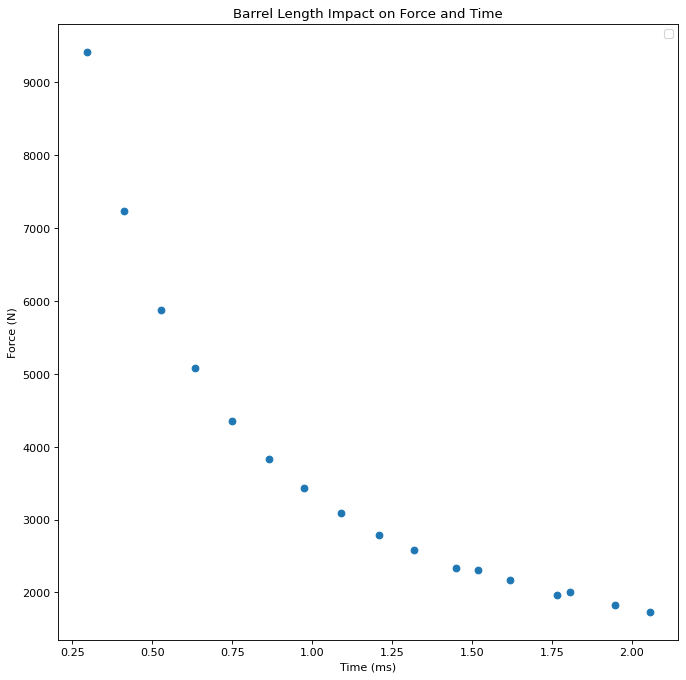

In [1736]:
yfig = 10;
xfig = 10;

plt.figure(num=1, figsize=(xfig,yfig), dpi=80)
plt.scatter(1e3 * AccelProf["Time Table"], AccelProf["Average Force On Bolt"])
plt.legend()
plt.title('Barrel Length Impact on Force and Time')
plt.xlabel('Time (ms)')
plt.ylabel('Force (N)')

plt.show()

Open Bolt Movement

In [1737]:
#Sear Drop
#Cartridge Feed
#Chambering Round
#Ignition at chambering
#Extraction from Chamber
#Free Travel
#Ejection of Cartridge
#Travel to buffer
#Buffer Bound
#Sear Catch

#Position = 0 means bolt at face
#Position along the path of motion measured positively, negative implies bolt face is in front of breech
#This measure restorative forces will all be negative

Simple Blowback Bolt State Change Conditions

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


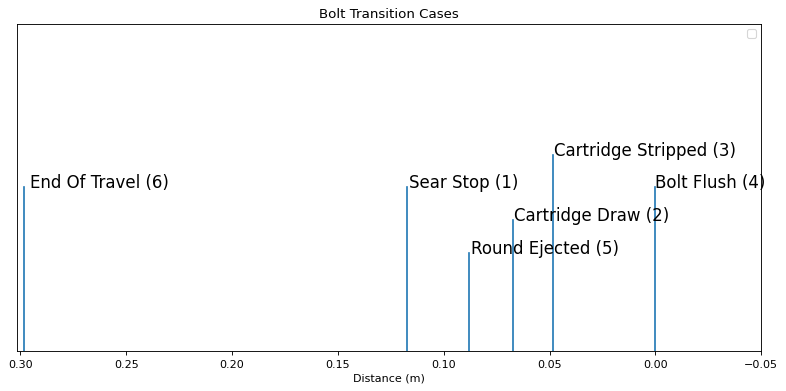

In [1738]:
BoltCondition = {}
BoltCondition["Sear Stop"] = Bolt["Sear Catch Headspace"]
BoltCondition["Cartridge Draw"] = Bolt["Sear Catch Headspace"] - 0.05
BoltCondition["Cartridge Pulled"] = BoltCondition["Cartridge Draw"] - Projectile["Case Length"] 
BoltCondition["RoundEjected"] = (0.75 * Bolt["Sear Catch Headspace"])
BoltCondition["End of Travel"] = Bolt["Total Travel Distance"]
BoltCondition["Bolt Flush"] = 0
yfig = 5;
xfig = 10;

plt.figure(num=1, figsize=(xfig,yfig), dpi=80)
plt.axvline(BoltCondition["Sear Stop"], ymin=0, ymax = 0.5)
plt.text(BoltCondition["Sear Stop"]*0.99,0.5,'Sear Stop (1)',fontsize=15)

plt.axvline(BoltCondition["Cartridge Draw"], ymin=0, ymax = 0.4)
plt.text(BoltCondition["Cartridge Draw"]*0.99,0.4,'Cartridge Draw (2)',fontsize=15)

plt.axvline(BoltCondition["Cartridge Pulled"], ymin=0, ymax = 0.6)
plt.text(BoltCondition["Cartridge Pulled"]*0.99,0.6,'Cartridge Stripped (3)',fontsize=15)

plt.axvline(BoltCondition["Bolt Flush"], ymin=0, ymax = 0.5)
plt.text(BoltCondition["Bolt Flush"]*0.99,0.5,'Bolt Flush (4)',fontsize=15)

plt.axvline(BoltCondition["RoundEjected"], ymin=0, ymax = 0.3)
plt.text(BoltCondition["RoundEjected"]*0.99,0.3,'Round Ejected (5)',fontsize=15)

plt.axvline(BoltCondition["End of Travel"], ymin=0, ymax = 0.5)
plt.text(BoltCondition["End of Travel"]*0.99,0.5,'End Of Travel (6)',fontsize=15)

plt.gca().invert_xaxis()
plt.xlim([BoltCondition["End of Travel"]*1.01, -.05])
plt.yticks([])
plt.title('Bolt Transition Cases')
plt.xlabel('Distance (m)')
plt.legend()
plt.tight_layout()

Force Balance

In [1739]:
def SpringForce(position):
    SpringForceOnBolt = -Bolt["Spring"] * (position + Bolt["BaseSpringCompression"])
    return SpringForceOnBolt

def CombustionForce(Barrel_Length):
    Force = Barrel2TimeAndForce(Barrel_Length)
    return Force[0,1]

def ChamberForce(mass, distance, velocity, springRate):
    KineticForceComp = (mass * velocity ** 2)/(2 * distance)
    SpringForceComp = 0.5 * springRate * (distance ** 2 + 2 * distance * Bolt["BaseSpringCompression"]) * np.reciprocal(distance)
    Force = KineticForceComp + 0.99 * SpringForceComp
    return Force

def SpringEnergy(InitialPos, FinalPos, BaseCompression, springRate):
    Energy1 = 0.5 * springRate * (InitialPos ** 2) - 0.5 * springRate * (FinalPos ** 2)
    Energy2 = 0.5 * springRate * ((InitialPos + BaseCompression) ** 2) - 0.5 * springRate * ((FinalPos + BaseCompression) ** 2)

    return np.column_stack((Energy1,Energy2))


sneed = ChamberForce(Bolt["Mass"], 0.048314206778798004, -3.7832478205307107, Bolt["Spring"])
print(sneed)


69.02023488267025


Simple Blowback Initialization

In [1740]:
BoltAnalysis = {}
BoltAnalysis["Bolt Mass"] = []
BoltAnalysis["Position"] = [] #m
BoltAnalysis["Velocity"] = []
BoltAnalysis["Motion Time"] = []

Initial Conditions

In [1741]:
initialCondition = {};
initialCondition["Bolt Mass"] = Bolt["Mass"]
initialCondition["Bolt Initial Position"] = Bolt["Sear Catch Headspace"]
initialCondition["Bolt Initial Velocity"] = 0
initialCondition["start_time"] = 0
initialCondition["end_time"] = 1.1 * 2 * np.pi * np.sqrt(np.divide(Bolt["Mass"],Bolt["Spring"]))


Simple Blowback Bolt Motion Models

In [1742]:
#Sear Drop
#Cartridge Magazine Strip
#Chambering Round
#Ignition at chambering
#Extraction from Chamber
#Free Travel
#Ejection of Cartridge
#Travel to buffer
#Buffer Bound
#Sear Catch

#Position = 0 means bolt at face
#Position along the path of motion measured positively, negative implies bolt face is in front of breech
#This measure restorative forces will all be negative

def SearDropMotion(t,y):
    BoltAnalysis["Position"].append(y[0])
    BoltAnalysis["Velocity"].append(y[1])

    BoltAnalysis["Motion Time"].append(t)

    BoltVel = y[1]
    BoltAccel = np.reciprocal(Bolt["Mass"]) * SpringForce(y[0])
    StateSpace = [BoltVel, BoltAccel]

    return StateSpace

def CartridgeStrip(t,y):
    BoltAnalysis["Position"].append(y[0])
    BoltAnalysis["Velocity"].append(y[1])

    BoltAnalysis["Motion Time"].append(t)

    BoltVel = y[1]
    BoltAccel = np.reciprocal(Bolt["Mass"]) * (SpringForce(y[0]) + Projectile["Magazine Extraction Friction"])
    StateSpace = [BoltVel, BoltAccel]
    
    return StateSpace

def CartridgeChamber(t,y):
    BoltAnalysis["Position"].append(y[0])
    BoltAnalysis["Velocity"].append(y[1])

    BoltAnalysis["Motion Time"].append(t)
    
    distance = 0.048314206778798004
    velocity = np.abs(-3.7832478205307107)
    FrictionForce = ChamberForce(Bolt["Mass"], distance, velocity, Bolt["Spring"])

    BoltVel = y[1]
    BoltAccel = np.reciprocal(Bolt["Mass"]) * (SpringForce(y[0]) + FrictionForce)
    StateSpace = [BoltVel, BoltAccel]
    
    return StateSpace

def IgnitionAndRetardation(t,y):
    BoltAnalysis["Position"].append(y[0])
    BoltAnalysis["Velocity"].append(y[1])

    BoltAnalysis["Motion Time"].append(t)

    BoltVel = y[1]
    BoltAccel = np.reciprocal(Bolt["Mass"]) * (SpringForce(y[0]) + CombustionForce(Barrel["Length"]))
    StateSpace = [BoltVel, BoltAccel]
    
    return StateSpace

def Extraction(t,y):
    BoltAnalysis["Position"].append(y[0])
    BoltAnalysis["Velocity"].append(y[1])

    BoltAnalysis["Motion Time"].append(t)

    BoltVel = y[1]
    BoltAccel = np.reciprocal(Bolt["Mass"]) * SpringForce(y[0])
    StateSpace = [BoltVel, BoltAccel]
    
    return StateSpace

def EndOfTravel(t,y):
    BoltAnalysis["Position"].append(y[0])
    BoltAnalysis["Velocity"].append(y[1])

    BoltAnalysis["Motion Time"].append(t)

    BoltVel = y[1]
    BoltAccel = np.reciprocal(Bolt["Mass"]) * (SpringForce(y[0]))
    StateSpace = [BoltVel, BoltAccel]
    
    return StateSpace

def BufferBounce(t,y):
    BoltAnalysis["Position"].append(y[0])
    BoltAnalysis["Velocity"].append(y[1])

    BoltAnalysis["Motion Time"].append(t)

    BoltVel = y[1]
    BoltAccel = np.reciprocal(Bolt["Mass"]) * (SpringForce(y[0]) - Bolt["Buffer Damping"] * y[1])
    StateSpace = [BoltVel, BoltAccel]
    
    return StateSpace

def Return2Sear(t,y):
    BoltAnalysis["Position"].append(y[0])
    BoltAnalysis["Velocity"].append(y[1])

    BoltAnalysis["Motion Time"].append(t)

    BoltVel = y[1]
    BoltAccel = np.reciprocal(Bolt["Mass"]) * SpringForce(y[0])
    StateSpace = [BoltVel, BoltAccel]
    
    return StateSpace


Termination Condition

In [1743]:
def MagazineExtraction(t, y): return (y[0] - BoltCondition["Cartridge Draw"])
MagazineExtraction.terminal = True;
MagazineExtraction.direction = -1;

def ExtractionComplete(t, y): return (y[0] - BoltCondition["Cartridge Pulled"])
ExtractionComplete.terminal = True;
ExtractionComplete.direction = -1;

def RoundChamber(t, y): return y[0]
RoundChamber.terminal = True;
RoundChamber.direction = -1;

def RoundEjection(t,y): return (y[0] - BoltCondition["RoundEjected"])
RoundEjection.terminal = True;
RoundEjection.direction = 1;

def RecieverImpact(t, y): return (y[0] - BoltCondition["End of Travel"])
RecieverImpact.terminal = True;
RecieverImpact.direction = 1;

def BufferBound(t,y): return y[1]
BufferBound.terminal = True;
BufferBound.direction = -1;

def SearCatch(t,y): return (y[0] - BoltCondition["Sear Stop"])
SearCatch.terminal = True;
SearCatch.direction = -1;

Simple Blowback Solver

In [1744]:
#Only uncomment ONE at a time for solver types

# solver_type = "RK45"
# solver_type = "RK23"
# solver_type = "DOP853"
# solver_type = "Radau"
# solver_type = "BDF"
solver_type = "LSODA"

#Keep this a small number
step_max = 0.00001;

All Motion Models

In [1745]:
def MotionAfterSearDrop(model):
    t_span = initialCondition["time_span"]
    BoltAnalysis["Sear_drop_motion"] = sp.integrate.solve_ivp(model, t_span, initialCondition["IC"],dense_output=True, max_step = step_max, events = MagazineExtraction, method=solver_type); #model = SearDropMotion
    
    sim_time = np.interp(BoltCondition["Cartridge Draw"], BoltAnalysis["Position"], BoltAnalysis["Motion Time"])

    x_pos = np.interp(sim_time,BoltAnalysis["Motion Time"], BoltAnalysis["Position"])
    x_vel = np.interp(sim_time,BoltAnalysis["Motion Time"], BoltAnalysis["Velocity"])
    
    return x_pos, x_vel, sim_time

def MotionDuringCartridgeStrip(model):
    t_span = initialCondition["time_span"]
    BoltAnalysis["CartridgeStrip_motion"] = sp.integrate.solve_ivp(model, t_span, initialCondition["IC"],dense_output=True, max_step = step_max, events = ExtractionComplete, method=solver_type); #model = CartridgeStrip
    
    sim_time = np.interp(BoltCondition["Cartridge Pulled"], BoltAnalysis["Position"], BoltAnalysis["Motion Time"])

    x_pos = np.interp(sim_time,BoltAnalysis["Motion Time"], BoltAnalysis["Position"])
    x_vel = np.interp(sim_time,BoltAnalysis["Motion Time"], BoltAnalysis["Velocity"])
    
    return x_pos, x_vel, sim_time

def MotionDuringCartridgeChamber(model):
    t_span = initialCondition["time_span"]
    BoltAnalysis["CartridgeChamber_motion"] = sp.integrate.solve_ivp(model, t_span, initialCondition["IC"],dense_output=True, max_step = step_max, events = RoundChamber, method=solver_type); #model = CartridgeChamber
    
    sim_time = np.interp(BoltCondition["Bolt Flush"], BoltAnalysis["Position"], BoltAnalysis["Motion Time"])

    x_pos = np.interp(sim_time,BoltAnalysis["Motion Time"], BoltAnalysis["Position"])
    x_vel = np.interp(sim_time,BoltAnalysis["Motion Time"], BoltAnalysis["Velocity"])
    return x_pos, x_vel, sim_time

def MotionDuringIgnitionAndRetardation(model):
    t_span = initialCondition["time_span"]
    BoltAnalysis["IgnitionAndRetardation_motion"] = sp.integrate.solve_ivp(model, t_span, initialCondition["IC"],dense_output=True, max_step = step_max, method=solver_type); #model = IgnitionAndRetardation
    
    sim_time = np.interp(BoltCondition["Cartridge Draw"], BoltAnalysis["Position"], BoltAnalysis["Motion Time"]) #Add Edge Transition Condition here

    x_pos = np.interp(sim_time,BoltAnalysis["Motion Time"], BoltAnalysis["Position"])
    x_vel = np.interp(sim_time,BoltAnalysis["Motion Time"], BoltAnalysis["Velocity"])
    return x_pos, x_vel, sim_time

def MotionDuringExtraction(model):
    t_span = initialCondition["time_span"]
    BoltAnalysis["Extraction_motion"] = sp.integrate.solve_ivp(model, t_span, initialCondition["IC"],dense_output=True, max_step = step_max, events = RoundEjection, method=solver_type); #model = Extraction

    sampleRear = -100
    sim_time = np.interp(BoltCondition["RoundEjected"], BoltAnalysis["Position"][sampleRear:], BoltAnalysis["Motion Time"][sampleRear:])

    x_pos = np.interp(sim_time,BoltAnalysis["Motion Time"], BoltAnalysis["Position"])
    x_vel = np.interp(sim_time,BoltAnalysis["Motion Time"], BoltAnalysis["Velocity"])
    return x_pos, x_vel, sim_time

def MotionUntilEndOfTravel(model):
    t_span = initialCondition["time_span"]
    BoltAnalysis["EndOfTravel_motion"] = sp.integrate.solve_ivp(model, t_span, initialCondition["IC"],dense_output=True, max_step = step_max, events = RecieverImpact, method=solver_type); #model = EndOfTravel
    
    sim_time = np.interp(BoltCondition["End of Travel"], BoltAnalysis["Position"], BoltAnalysis["Motion Time"])

    x_pos = np.interp(sim_time,BoltAnalysis["Motion Time"], BoltAnalysis["Position"])
    x_vel = np.interp(sim_time,BoltAnalysis["Motion Time"], BoltAnalysis["Velocity"])
    return x_pos, x_vel, sim_time

def MotionAtBufferBounce(model):
    t_span = initialCondition["time_span"]
    BoltAnalysis["EndOfTravel_motion"] = sp.integrate.solve_ivp(model, t_span, initialCondition["IC"],dense_output=True, max_step = step_max, events = BufferBound, method=solver_type); #model = EndOfTravel
    
    Sample_Point = BoltCondition["End of Travel"] + Bolt["Buffer Width"]
    sim_time = np.interp(Sample_Point, BoltAnalysis["Position"], BoltAnalysis["Motion Time"])

    x_pos = np.interp(sim_time,BoltAnalysis["Motion Time"], BoltAnalysis["Position"])
    x_vel = np.interp(sim_time,BoltAnalysis["Motion Time"], BoltAnalysis["Velocity"])
    return x_pos, x_vel, sim_time

def MotionReturning2Sear(model):
    t_span = initialCondition["time_span"]
    BoltAnalysis["IgnitionAndRetardation_motion"] = sp.integrate.solve_ivp(model, t_span, initialCondition["IC"],dense_output=True, max_step = step_max, events = SearCatch, method=solver_type); #model = Return2Sear
    
    sim_time = np.interp(BoltCondition["Sear Stop"], BoltAnalysis["Position"], BoltAnalysis["Motion Time"])

    x_pos = np.interp(sim_time,BoltAnalysis["Motion Time"], BoltAnalysis["Position"])
    x_vel = np.interp(sim_time,BoltAnalysis["Motion Time"], BoltAnalysis["Velocity"])
    return x_pos, x_vel, sim_time

Motion Solution

In [1746]:
def BoltMotionSolution():
    initialCondition["time_span"] = [initialCondition["start_time"], initialCondition["end_time"]]
    initialCondition["IC"] = [initialCondition["Bolt Initial Position"], initialCondition["Bolt Initial Velocity"]]
    EndState =  MotionAfterSearDrop(SearDropMotion)

    initialCondition["IC"] = EndState[0:-1]
    initialCondition["time_span"] = [EndState[-1], initialCondition["end_time"]]
    EndState =  MotionDuringCartridgeStrip(CartridgeStrip)
    
    initialCondition["IC"] = EndState[0:-1]
    initialCondition["time_span"] = [EndState[-1], initialCondition["end_time"]]
    EndState =  MotionDuringCartridgeChamber(CartridgeChamber)

    initialCondition["IC"] = [0,0]
    initialCondition["time_span"] = [EndState[-1], EndState[-1] + ForceProfile["Kinematics Force"][0,0]]
    EndState =  MotionDuringIgnitionAndRetardation(IgnitionAndRetardation)

    initialCondition["IC"] = EndState[0:-1]
    initialCondition["time_span"] = [EndState[-1], initialCondition["end_time"]]
    EndState =  MotionDuringExtraction(Extraction)

    initialCondition["IC"] = EndState[0:-1]
    initialCondition["time_span"] = [EndState[-1], initialCondition["end_time"]]
    EndState =  MotionUntilEndOfTravel(EndOfTravel)

    # print(len(BoltAnalysis["Velocity"]))
    initialCondition["IC"] = EndState[0:-1]
    initialCondition["time_span"] = [EndState[-1], initialCondition["end_time"]]
    EndState =  MotionAtBufferBounce(BufferBounce)
    # print(len(BoltAnalysis["Velocity"]))

    initialCondition["IC"] = [EndState[0],0]
    initialCondition["time_span"] = [EndState[-1], initialCondition["end_time"]]
    EndState =  MotionReturning2Sear(Return2Sear)
    
    initialCondition["IC"] = EndState[0:-1]
    return initialCondition["IC"]

BoltSolutionSpace = [];
BoltSolutionSpace = BoltMotionSolution()

DataSpring = np.multiply(BoltAnalysis["Position"], Bolt["Spring"])


BufferForce = np.multiply(Bolt["Buffer Damping"], BoltAnalysis["Velocity"])


Graphic Display of Simple Blowback Motion

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


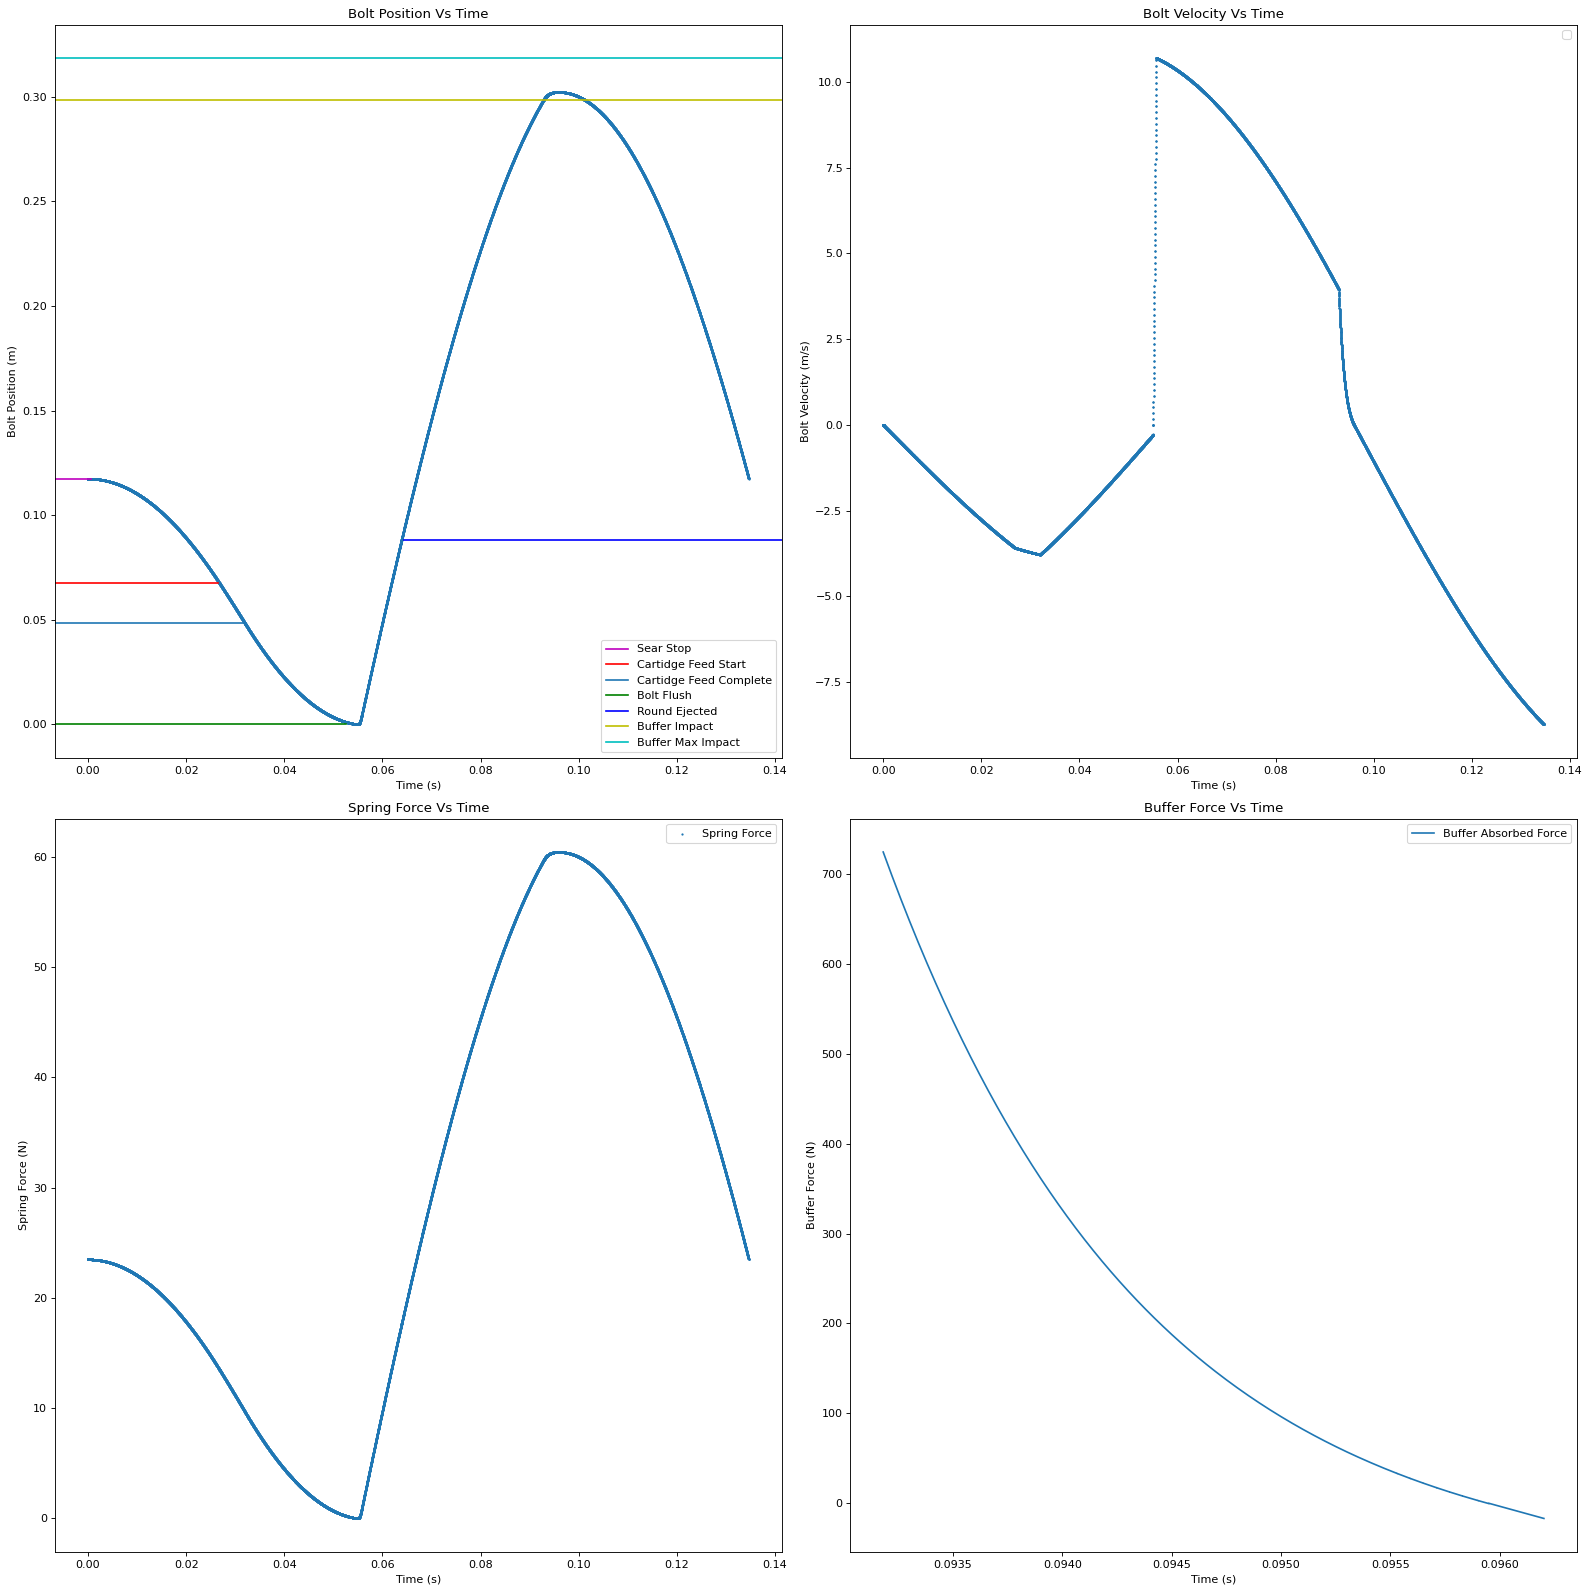

In [1747]:

yfig = 20;
xfig = 20;
plt.figure(num=1, figsize=(xfig,yfig), dpi=80)
plt.subplot(221)
plt.scatter(BoltAnalysis["Motion Time"], BoltAnalysis["Position"], s=1)
plt.axhline(BoltCondition["Sear Stop"], xmax=0.05, label="Sear Stop", color = 'm')
plt.axhline(BoltCondition["Cartridge Draw"], xmax=0.225, label="Cartidge Feed Start", color = 'r')
plt.axhline(BoltCondition["Cartridge Pulled"], xmax=0.26, label="Cartidge Feed Complete")
plt.axhline(BoltCondition["Bolt Flush"], xmax=0.4, label="Bolt Flush", color = 'g')
plt.axhline(BoltCondition["RoundEjected"],xmin=0.48, label="Round Ejected", color = 'b')
plt.axhline(BoltCondition["End of Travel"], label="Buffer Impact", color = 'y')
plt.axhline(BoltCondition["End of Travel"]  + Bolt["Buffer Width"], label="Buffer Max Impact", color = 'c')
plt.title('Bolt Position Vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Bolt Position (m)')
plt.legend()

plt.subplot(222)
plt.scatter(BoltAnalysis["Motion Time"], BoltAnalysis["Velocity"], s=1)
plt.title('Bolt Velocity Vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Bolt Velocity (m/s)')
plt.legend()

plt.subplot(223)
plt.scatter(BoltAnalysis["Motion Time"], DataSpring, s=1,label='Spring Force')
plt.title('Spring Force Vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Spring Force (N)')
plt.legend()

plt.subplot(224)
plt.plot(BoltAnalysis["Motion Time"][9504:10127], BufferForce[9504:10127], label='Buffer Absorbed Force')
plt.title('Buffer Force Vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Buffer Force (N)')
plt.legend()

plt.tight_layout()

Roller Delayed Movement

Long Stroke Gas Piston Movement

Internal Piston Movement